In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# from tqdm import tqdm
from tqdm.notebook import tqdm
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from pycbc.detector import Detector

# local packages
from gwpe.parameters import ParameterGenerator
from gwpe.waveforms import generate_intrinsic_waveform, batch_project
from gwpe.noise import load_psd_from_file, get_tukey_window
from gwpe.utils import read_ini_config

In [3]:
## note
# there's not necessarily a need to use config files
# but its a convenient container for now

# load config files that specify parameter priors
intrinsics_ini = "gwpe/config_files/intrinsics.ini"
extrinsics_ini = "gwpe/config_files/extrinsics.ini"

# load static argument config file
static_args_ini = "gwpe/config_files/static_args.ini"
_, static_args = read_ini_config(static_args_ini)
static_args

{'approximant': 'IMRPhenomPv2',
 'domain': 'frequency',
 'f_lower': 20.0,
 'f_ref': 20.0,
 'f_final': 1024.0,
 'waveform_length': 8.0,
 'distance': 100.0,
 'original_sampling_rate': 4096.0,
 'target_sampling_rate': 4096.0,
 'seconds_before_event': 6.0,
 'seconds_after_event': 2.0,
 'tukey_alpha': 0.1,
 'sample_length': 8.0,
 'delta_t': 0.000244140625,
 'delta_f': 0.125,
 'td_length': 32768,
 'fd_length': 8193}

In [4]:
# generate parameters
n = 100
generators = {
    "intrinsics": ParameterGenerator(config_files=intrinsics_ini, seed=None),
    "extrinsics": ParameterGenerator(config_files=extrinsics_ini, seed=None)
}

parameters = {key: generators[key].draw(n, as_df=True) for key in generators}
samples = {key: parameters[key].to_records() for key in parameters}  # record arrays are a PyCBC artefact
for key in parameters:
    display(parameters[key])

,mass_1,mass_2,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,theta_jn
0,64.177532,59.015816,1.042994,0.005338,0.138049,1.908990,2.727051,4.473016,3.444957,2.707723
1,66.562855,37.834017,0.390005,0.749215,0.751745,2.015947,0.321593,3.299032,4.334622,1.038725
2,48.954298,25.537641,2.274320,0.496208,0.275875,0.973792,0.960399,4.781181,1.975607,0.461091
3,29.517188,11.922452,1.537333,0.138508,0.198094,1.468538,0.644252,3.086828,5.505650,1.625861
4,42.152140,17.017101,2.821430,0.841160,0.591265,0.828347,2.117414,1.636190,0.630032,2.333445
...,...,...,...,...,...,...,...,...,...,...
95,56.789151,17.982359,0.311719,0.698964,0.030275,0.856740,0.490719,2.197233,2.438930,2.889356
96,19.088685,13.717124,5.056407,0.310248,0.634509,2.776193,1.785483,0.078974,1.291640,1.784450
97,11.047769,10.536686,1.393259,0.280243,0.813082,2.302841,1.073079,2.633993,3.989058,2.412655
98,71.492134,51.531985,0.926933,0.430996,0.620440,0.665517,2.087128,4.495391,6.037839,1.161027


,psi,ra,dec,distance
0,1.213346,3.320314,-1.139616,370.766180
1,2.634715,5.505901,0.671972,262.027603
2,2.614584,0.404708,0.404383,833.367870
3,2.540914,2.592753,-0.102395,864.524143
4,1.430414,1.878498,-0.488287,288.999543
...,...,...,...,...
95,2.148206,5.493802,-0.619308,333.238573
96,0.618739,2.937664,1.088505,906.617280
97,2.344664,5.243780,-0.270922,637.193235
98,0.993157,5.051068,-0.282072,884.741964


shape of psd for ('H1', 'L1'): (2, 8193)
shape of psd[None] for ('H1', 'L1'): (1, 2, 8193)


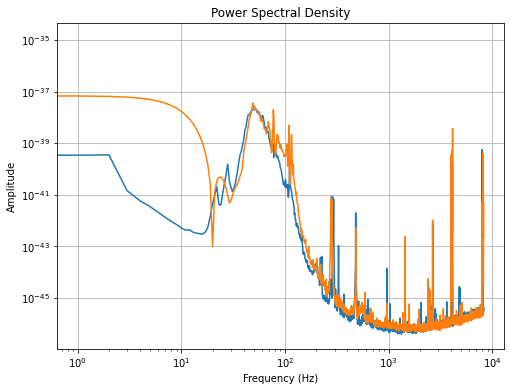

In [76]:
# specify interferometers
ifos = ("H1", "L1")
detectors = {ifo: Detector(ifo) for ifo in ifos}

# load example PSDs from file
psds = np.stack([load_psd_from_file(f"PSD/{ifo}_PSD.npy", delta_f=static_args['delta_f']) for ifo in ifos])

# truncate up to 1024Hz inclusive
# to do: load_psd_from_file truncates "exclusively"
# i.e. it returns a (2, 8192) shaped array
psds = psds[:, :static_args["fd_length"]]

# display
print(f"shape of psd for {ifos}: {psds.shape}")
print(f"shape of psd[None] for {ifos}: {psds[None].shape}")

# plot PSD from first sample
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
for i, ifo in enumerate(ifos):
    ax.plot(psds[i], label=ifo)
ax.set(title="Power Spectral Density", ylabel='Amplitude', xlabel="Frequency (Hz)", yscale="log", xscale="log")
ax.grid('both')
fig.show()

### Frequency Domain Waveforms

In [6]:
# generate intrinsic waveforms with plus and cross polarisations
waveforms = np.stack([generate_intrinsic_waveform(sample, static_args) for sample in tqdm(samples["intrinsics"])])
projections = np.stack([batch_project(detectors[i], samples['extrinsics'], waveforms, static_args) for i in ifos], axis=1)
print(f"shape of waveforms for {ifos}: {waveforms.shape}")
print(f"shape of projections for {ifos}: {projections.shape}")

  0%|          | 0/100 [00:00<?, ?it/s]

shape of waveforms for ('H1', 'L1'): (100, 2, 8193)
shape of projections for ('H1', 'L1'): (100, 2, 8193)


shape of whitened_projections for ('H1', 'L1'): (100, 2, 8193)


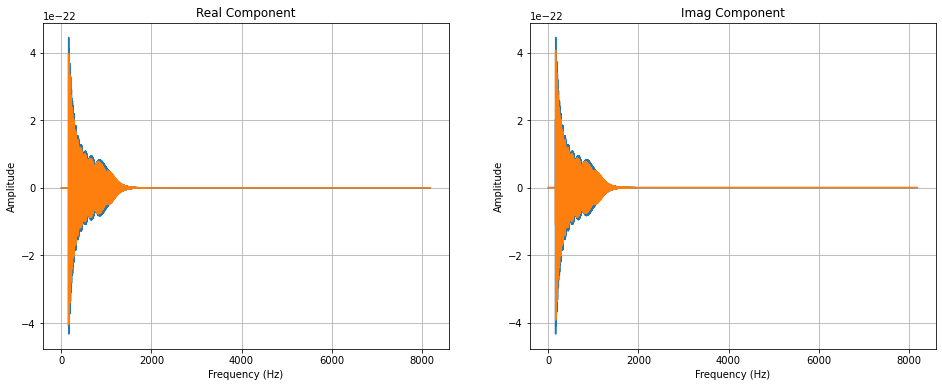

In [139]:
# whiten waveforms in batch
# the psd array is broadcasted (replicated without memory cost) to match the number of waveforms
whitened_projections = projections# / (psds[None]**0.5)  # equivalent to psds[None, :, :]; prepending an empty
print(f"shape of whitened_projections for {ifos}: {whitened_projections.shape}")

# optionally we could also set f_lower to 0 (highpass filter)
# whitened_projections[:, :, :int(static_args["f_lower"]/static_args["delta_f"])] = 0.

# plot PSD from first sample
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
for i, ifo in enumerate(ifos):
    axes[0].plot(whitened_projections[0, i].real, label=ifo)
    axes[0].set_title("Real Component")
    axes[1].plot(whitened_projections[0, i].imag, label=ifo)
    axes[1].set_title("Imag Component")
for ax in axes:
    ax.set(ylabel='Amplitude', xlabel="Frequency (Hz)")
    ax.grid('both')
fig.show()

### Time Domain Waveforms

shape of time domain waveforms for ('H1', 'L1'): (100, 2, 32768); dtype: float64


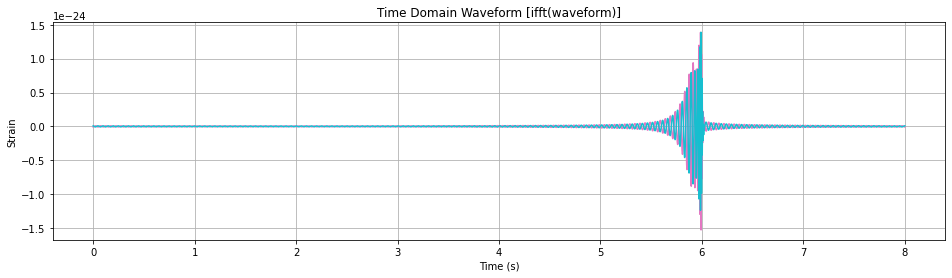

In [175]:
# https://stackoverflow.com/a/56272299
# norm = "ortho"
norm = None
timeseries = np.real_if_close(np.fft.ifft(projections, n=static_args["td_length"], norm=norm))
timestamps = np.linspace(0, static_args["sample_length"], static_args["td_length"])
print(f"shape of time domain waveforms for {ifos}: {timeseries.shape}; dtype: {timeseries.dtype}")

# plot plus / cross polarizations from first sample
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(timestamps, timeseries[0, 0], label='Plus', color='tab:pink')  # pink for plus
ax.plot(timestamps, timeseries[0, 1], label='Cross', color='tab:cyan')  # cyan for cross
ax.set(title="Time Domain Waveform [ifft(waveform)]", ylabel='Strain', xlabel="Time (s)")
ax.grid('both')
fig.show()

#### Windowing

We might wish to apply a window to the timeseries strain before performing FFT.

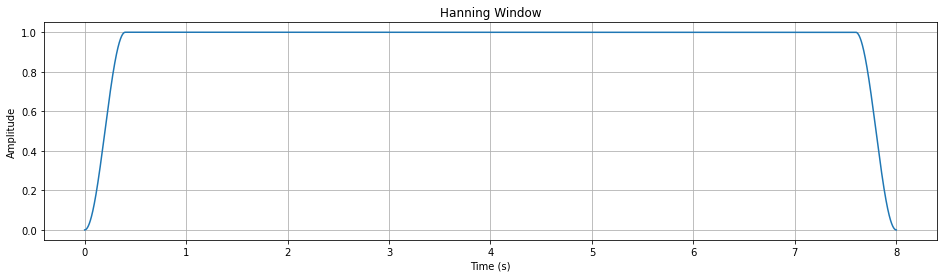

In [176]:
# apply window to timeseries before fft-ing back to frequency domain
window = get_tukey_window(static_args['sample_length'])  # ?
# window = np.hanning(static_args['td_length'] + 1)[:-1]

# plot plus / cross polarizations from first sample
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(timestamps, window)
ax.set(title="Hanning Window", ylabel='Amplitude', xlabel="Time (s)")
ax.grid('both')
fig.show()

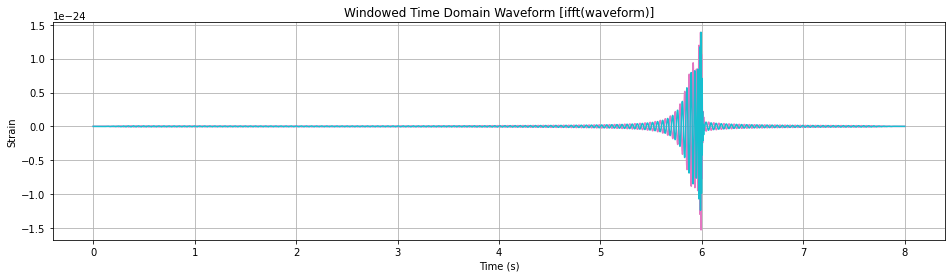

In [177]:
# plot plus / cross polarizations from first sample
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(timestamps, window*timeseries[0, 0], label='Plus', color='tab:pink')  # pink for plus
ax.plot(timestamps, window*timeseries[0, 1], label='Cross', color='tab:cyan')  # cyan for cross
ax.set(title="Windowed Time Domain Waveform [ifft(waveform)]", ylabel='Strain', xlabel="Time (s)")
ax.grid('both')
fig.show()

After np.fft.fft operation
shape of freq domain waveforms for ('H1', 'L1'): (100, 2, 32768); dtype: complex128
shape of frequency bins for ('H1', 'L1'): (32768,); dtype: float64

After reconstruction
shape of freq domain waveforms for ('H1', 'L1'): (100, 2, 8193); dtype: complex128
shape of frequency bins for ('H1', 'L1'): (8193,); dtype: float64

Final reconstruction matches original waveform? True


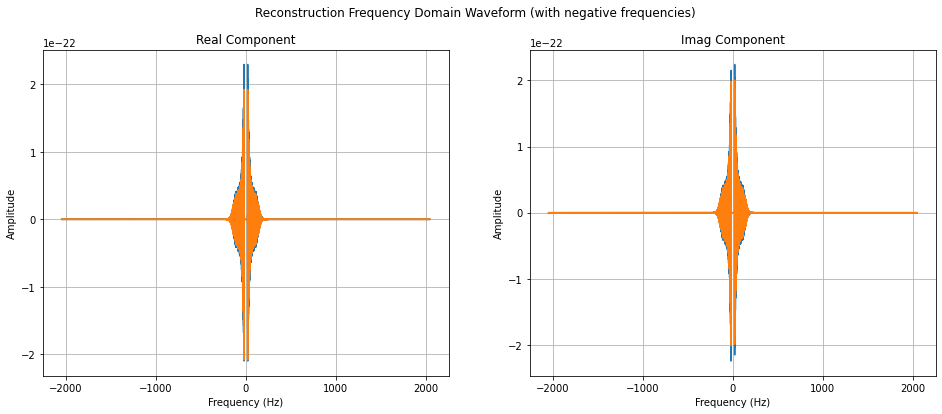

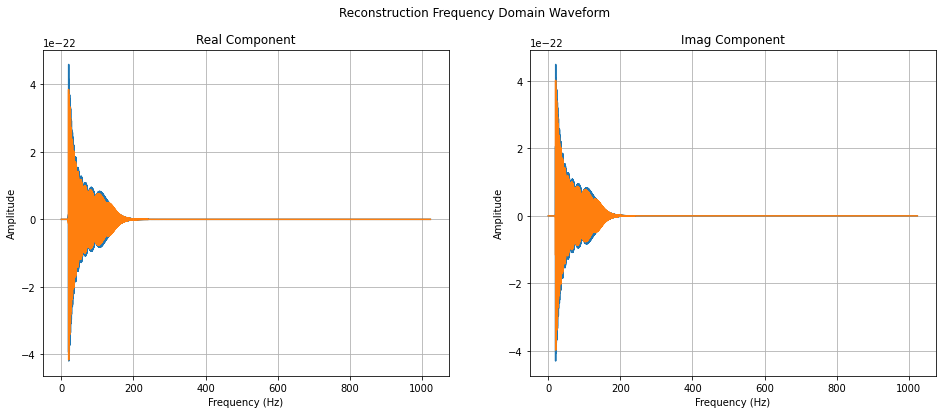

In [178]:
# fft
reconstructions = np.fft.fft((timeseries * window), axis=-1, norm=norm)
freq_bins = np.fft.fftfreq(timeseries.shape[-1], d=static_args['delta_t'])

print("After np.fft.fft operation")
print(f"shape of freq domain waveforms for {ifos}: {reconstructions.shape}; dtype: {reconstructions.dtype}")
print(f"shape of frequency bins for {ifos}: {freq_bins.shape}; dtype: {freq_bins.dtype}")

# plot PSD from first sample
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
for i, ifo in enumerate(ifos):
    axes[0].plot(freq_bins, reconstructions[0, i].real, label=ifo)
    axes[0].set_title("Real Component")
    axes[1].plot(freq_bins, reconstructions[0, i].imag, label=ifo)
    axes[1].set_title("Imag Component")
for ax in axes:
    ax.set(ylabel='Amplitude', xlabel="Frequency (Hz)")  # log removes negative x axis
    ax.grid('both')
fig.suptitle("Reconstruction Frequency Domain Waveform (with negative frequencies)")
fig.show()

# reconstruct frequency domain waveform as per https://dsp.stackexchange.com/a/19840
# if there are any errors in output expected from signal processing, start here
reconstructions = reconstructions[:, :, :(reconstructions.shape[-1] // 2)]*2
freq_bins = freq_bins[:(freq_bins.shape[-1] // 2)]

# truncate to 1024Hz down from 2048Hz
# there is little information related to CBC given astrophysical prior knowledge
# therefore our neural network (or any other function) can ignore these higher frequencies
reconstructions = reconstructions[:, :, :static_args["fd_length"]]
freq_bins = freq_bins[:static_args["fd_length"]]

print("\nAfter reconstruction")
print(f"shape of freq domain waveforms for {ifos}: {reconstructions.shape}; dtype: {reconstructions.dtype}")
print(f"shape of frequency bins for {ifos}: {freq_bins.shape}; dtype: {freq_bins.dtype}")

# plot PSD from first sample
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
for i, ifo in enumerate(ifos):
    axes[0].plot(freq_bins, reconstructions[0, i].real, label=ifo)
    axes[0].set_title("Real Component")
    axes[1].plot(freq_bins, reconstructions[0, i].imag, label=ifo)
    axes[1].set_title("Imag Component")
for ax in axes:
    ax.set(ylabel='Amplitude', xlabel="Frequency (Hz)")  # log removes negative x axis
    ax.grid('both')
fig.suptitle("Reconstruction Frequency Domain Waveform")
fig.show()

# ensure we've properly reconstructed the original frequency domain waveform
print(f"\nFinal reconstruction matches original waveform? {np.allclose(whitened_projections, reconstructions)}")

### Batched Timeseries Whitening

Assuming we start with a timeseries signal we would like to:
- Apply a window function to the timeseries strain (optional(?))
- Apply the FFT operation to all strains in batch
- Whiten the strain in the frequency domain with a given PSD
- Apply the inverse FFT to all strains in batch to correctly reconstruct the whitened waveform

### Signal Processing Questions

I still have some uncertainties about how inverse Fourier transforms are meant to work here, see below:

#### Fourier Transformations

When going from `timeseries -> frequencyseries` we perform the FFT, but then we ignore the negative frequency components returned by the fft, and double the amplitude of the positive frequency components. We've seen this mentioned here but I'm not 100% confident this is best practice: https://dsp.stackexchange.com/a/19840

The calculation of `freq_bins` via `np.fft.fftfreq` above suggests that the fft returns a frequency domain waveform with domain `[0Hz, 2048Hz]`, but we've truncated this to `1024Hz` to copy the implementations of some prior work (which justified this truncation by stating frequency components above 1024Hz are unlikely for BBH CBC anyway).

#### Inverse Fourier Transformations

When we have the frequency domain waveform, we can recover the timeseries properly.

When we whiten the frequency domain data however, the `np.real_if_close` function returns a `np.complex128` dtype even when `tol=0.1`- implying that the real and complex versions of this function are not equivalent even when accounting for floating point precision error. However, if we don't apply any whitening, `np.real_if_close` functions as expected and we get a real-valued timeseries waveform. This phenomena probably warrants some investigation, as we're not entirely sure if we're doing proper signal processing or using numpy functions as intended.

To summarise this last point, see below:

- If we do not whiten the frequency domain waveform, both approaches `ifft(frequencyseries).real*2` and `irfft(frequencyseries)` appear to produce equivalent real-valued timeseries outputs.
- However, whitening the frequency domain output does introduce a discrepancy between these two approaches. We *assume* this is expected and that a `1e-4` tolerace for floating point precision error is acceptable.

To be extremely certain that this `numpy` based vectorised implementation is correct, it might make sense to compare the output to how it might be handled in a PyCBC implementation.

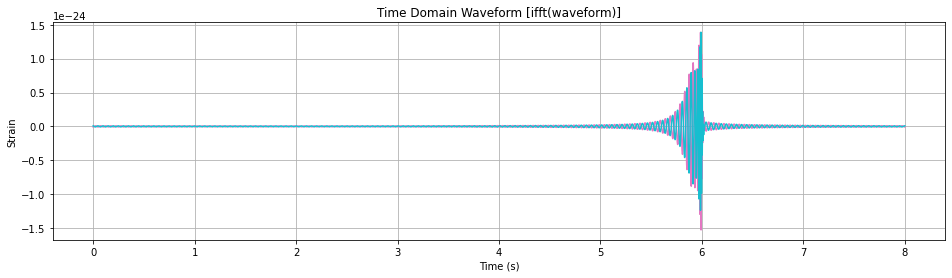

In [181]:
# plot plus / cross polarizations from first sample
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(timestamps, timeseries[0, 0], label='Plus', color='tab:pink')  # pink for plus
ax.plot(timestamps, timeseries[0, 1], label='Cross', color='tab:cyan')  # cyan for cross
ax.set(title="Time Domain Waveform [ifft(waveform)]", ylabel='Strain', xlabel="Time (s)")
ax.grid('both')
fig.show()

In [263]:
## compute whitened frequency domain waveform

# fourier transformation
frequencyseries = np.fft.fft((timeseries * window), axis=-1)                  # FFT windowed timeseries
frequencyseries = frequencyseries[:, :, :(frequencyseries.shape[-1] // 2)]*2  # construct real component
frequencyseries = frequencyseries[:, :, :static_args["fd_length"]]            # truncate to 1024Hz

# apply highpass filter
f_lower_idx = int(static_args["f_lower"]/static_args["delta_f"])
frequencyseries[:, :, :f_lower_idx] = 0.                                                   # highpass filter

# whiten non-zero elements on the waveform (this has carry-on effects for IFFT, see markdown section above)
frequencyseries = frequencyseries[:, :, f_lower_idx:] / (psds[None, :, f_lower_idx:]**0.5)

np.real_if_close(whitened_timeseries) dtype: complex128
shape of whitened_timeseries for ('H1', 'L1'): (100, 2, 32768); dtype: float64


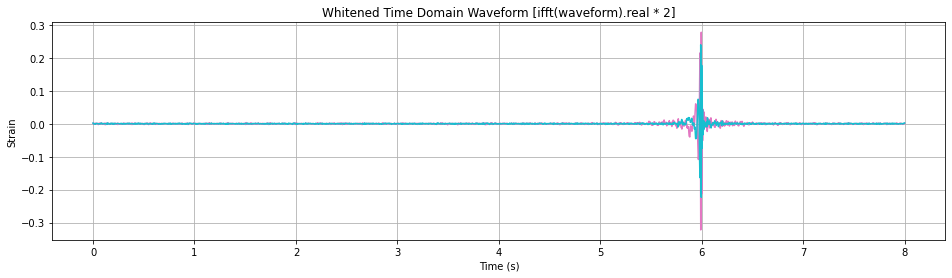

In [264]:
# reconstruct the timeseries after whitening
whitened_timeseries = np.real_if_close(np.fft.ifft(frequencyseries, n=static_args["td_length"]))  # complex??
print(f"np.real_if_close(whitened_timeseries) dtype: {whitened_timeseries.dtype}")  # try this without whitening

whitened_timeseries = whitened_timeseries.real * 2  # do we need to do this?
print(f"shape of whitened_timeseries for {ifos}: {whitened_timeseries.shape}; dtype: {whitened_timeseries.dtype}")

# plot plus / cross polarizations from first sample
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(timestamps, whitened_timeseries[0, 0].real, label='Plus', color='tab:pink')  # pink for plus
ax.plot(timestamps, whitened_timeseries[0, 1].real, label='Cross', color='tab:cyan')  # cyan for cross
ax.set(title="Whitened Time Domain Waveform [ifft(waveform).real * 2]", ylabel='Strain', xlabel="Time (s)")
ax.grid('both')
fig.show()

shape of whitened_timeseries for ('H1', 'L1'): (100, 2, 32768); dtype: float64


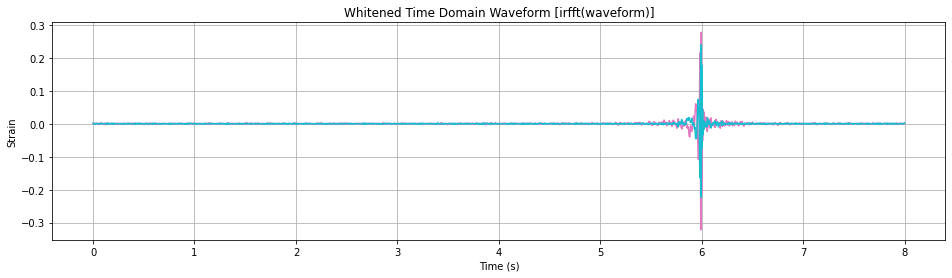

In [265]:
# reconstruct the timeseries after whitening
whitened_timeseries = np.fft.irfft(frequencyseries, n=static_args["td_length"])
print(f"shape of whitened_timeseries for {ifos}: {whitened_timeseries.shape}; dtype: {whitened_timeseries.dtype}")

# plot plus / cross polarizations from first sample
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(timestamps, whitened_timeseries[0, 0].real, label='Plus', color='tab:pink')  # pink for plus
ax.plot(timestamps, whitened_timeseries[0, 1].real, label='Cross', color='tab:cyan')  # cyan for cross
ax.set(title="Whitened Time Domain Waveform [irfft(waveform)]", ylabel='Strain', xlabel="Time (s)")
ax.grid('both')
fig.show()

In [266]:
# what's the difference with the above two approaches?
a = np.fft.irfft(frequencyseries, n=static_args["td_length"])
b = np.fft.ifft(frequencyseries, n=static_args["td_length"]).real * 2

# identical within 1e-4 precision (but maybe not 1e-5)
for atol in (1e-4, 1e-6, 1e-8):
    equivalent = np.allclose(a, b, atol=atol)
    print(f"irfft and ifft implementations are equivalent within {atol} precision?: {equivalent}")

irfft and ifft implementations are equivalent within 0.0001 precision?: True
irfft and ifft implementations are equivalent within 1e-06 precision?: False
irfft and ifft implementations are equivalent within 1e-08 precision?: False


In [267]:
## compute whitened frequency domain waveform

# fourier transformation
frequencyseries = np.fft.fft((timeseries * window), axis=-1)                  # FFT windowed timeseries
frequencyseries = frequencyseries[:, :, :(frequencyseries.shape[-1] // 2)]*2  # construct real component
frequencyseries = frequencyseries[:, :, :static_args["fd_length"]]            # truncate to 1024Hz

# apply highpass filter
f_lower_idx = int(static_args["f_lower"]/static_args["delta_f"])
frequencyseries[:, :, :f_lower_idx] = 0.                                      # highpass filter

# examine the same computations but without whitening

# what's the difference with the above two approaches?
a = np.fft.irfft(frequencyseries, n=static_args["td_length"])
b = np.fft.ifft(frequencyseries, n=static_args["td_length"]).real * 2

# identical within 1e-4 precision (but maybe not 1e-5)
for atol in (1e-4, 1e-6, 1e-8):
    equivalent = np.allclose(a, b, atol=atol)
    print(f"irfft and ifft implementations are equivalent within {atol} precision?: {equivalent}")

irfft and ifft implementations are equivalent within 0.0001 precision?: True
irfft and ifft implementations are equivalent within 1e-06 precision?: True
irfft and ifft implementations are equivalent within 1e-08 precision?: True


#### Convenience functions

In [285]:
from typing import Optional

# f_lower_idx is just calculated as follows
# f_lower_idx = int(static_args["f_lower"]/static_args["delta_f"])

def batched_whiten(
    timeseries: np.ndarray,
    window: Optional[np.ndarray]=None,
    psds: Optional[np.ndarray]=None,
    fd_length: Optional[int]=None,
    f_lower_idx: int=0,
) -> np.ndarray:
    """
    Function returns a whitened timeseries.
    
    The timeseries data is windowed if a window kernel of the same size is provided. 
    Then a np.fft.fft operation is applied in batch, followed by an optional highpass
    filterm specified by the f_lower_idx input argument. If a PSD is supplied we whiten 
    the waveform in the frequency domain, then ifft it back to a real-valued timeseries.
    
    TO DO:
    
    Currently we have only tested unique PSD for each IFO, but the same PSD is applied
    to all the samples in the batch of waveforms (N). It should be simple enough to allow
    for N potentially different PSDs or each C IFOs (C being arbitrary "channels"), which
    would whiten a batch of waveforms for each IFO according to different noise signatures.
    Ideally all that would be required is to change the input `psds` array.
    
    This could be useful for training neural networks conditional on broad PSD distributions.
    
    Arguments:
        timeseries: np.ndarray
            The real-valued timeseries array in batch, of shape [N, C, L]
        window: np.ndarray
            An optional windowing function to apply to the timeseries of shape [,L]
        psds: np.ndarray
            An frequency domain array describing the PSD for whitening, of shape [C, L]
        f_lower_idx: int
            If this is non-zero, we set indices below this value are set to 0 (highpass filter).
        fd_length: int
            The length of the frequency domain waveform for FFT. If psds is provided, we use that shape.
            
    Returns: np.ndarray
        The whitened timeseries array of the same shape as the input.
            
    """
    # optionally apply window
    if window is not None:
        assert timeseries.shape[-1] == window.shape[-1]
        ts = timeseries * window
    else:
        ts = timeseries
        
    td_length = ts.shape[-1]
    if fd_length is None and psds is not None:
        fd_length = psds.shape[-1]

    # fourier transformation
    frequencyseries = np.fft.fft(ts, axis=-1)                                     # FFT windowed timeseries
    frequencyseries = frequencyseries[:, :, :(frequencyseries.shape[-1] // 2)]*2  # construct real component
    frequencyseries = frequencyseries[:, :, :fd_length]                           # truncate to psd length

    # apply highpass filter
    frequencyseries[:, :, :f_lower_idx] = 0.                                      # highpass filter

    # whiten non-zero elements on the waveform
    if psds is not None:
        assert len(psds.shape) in (2, 3), "psd must either a 2-d or 3-d numpy array"
        assert psds.shape[-2] == frequencyseries.shape[-2], "psd and fft(timeseries) length don't match"
        assert psds.shape[-1] == fd_length, "psds.shape[-1] does not match input fd_length"
        if len(psds.shape) == 3:
            frequencyseries = frequencyseries[:, :, f_lower_idx:] / (psds[:, :, f_lower_idx:]**0.5)
        else:
            frequencyseries = frequencyseries[:, :, f_lower_idx:] / (psds[None, :, f_lower_idx:]**0.5)
            
    # either of these should be fine...?
#     return np.fft.ifft(frequencyseries, n=td_length).real * 2
    return np.fft.irfft(frequencyseries, n=td_length)

### Demonstration of function

timeseries.shape: (100, 2, 32768)
window.shape: (32768,)
psds.shape: (2, 8193)


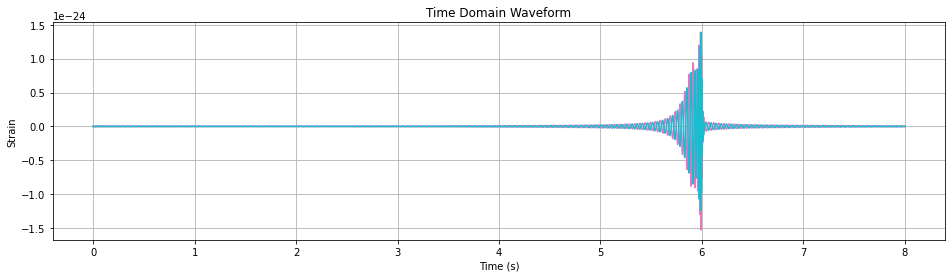

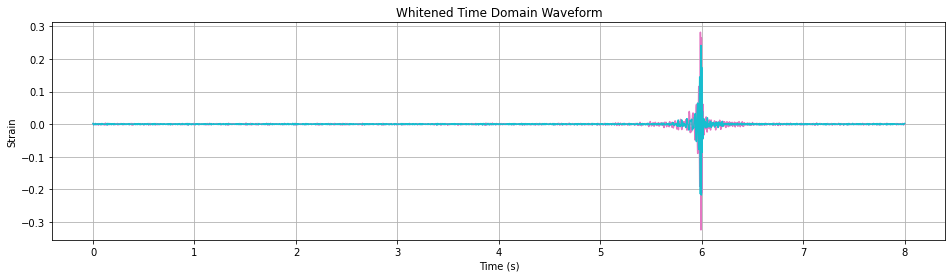

In [289]:
# plot plus / cross polarizations from first sample
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(timestamps, timeseries[0, 0], label='Plus', color='tab:pink')  # pink for plus
ax.plot(timestamps, timeseries[0, 1], label='Cross', color='tab:cyan')  # cyan for cross
ax.set(title="Time Domain Waveform", ylabel='Strain', xlabel="Time (s)")
ax.grid('both')
fig.show()

# apply window to timeseries before fft-ing back to frequency domain
# window = get_tukey_window(static_args['sample_length'])
# window = np.hanning(static_args['td_length'] + 1)[:-1]

print(f'timeseries.shape: {timeseries.shape}')
print(f'window.shape: {window.shape}')
print(f'psds.shape: {psds.shape}')
out = batched_whiten(timeseries, window, psds)

# plot plus / cross polarizations from first sample
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(timestamps, out[0, 0], label='Plus', color='tab:pink')  # pink for plus
ax.plot(timestamps, out[0, 1], label='Cross', color='tab:cyan')  # cyan for cross
ax.set(title="Whitened Time Domain Waveform", ylabel='Strain', xlabel="Time (s)")
ax.grid('both')
fig.show()